In [1]:
import yfinance as yf
import pandas as pd
import datetime
from statistics import mean
import matplotlib.pyplot as plt #pyplot package under the matplotlib package
import seaborn as sns
import math

plt.style.use("ggplot")
 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [491]:
ticker = yf.Ticker("0700.hk")

In [492]:
ticker.info["longBusinessSummary"]
# ticker.info["logo_url"]

"Tencent Holdings Limited, an investment holding company, provides value-added services (VAS) and Online advertising services in Mainland China and internationally. The company operates through VAS, Online Advertising, FinTech and Business Services, and Others segments. It offers online games and social network services; FinTech and cloud services, and online advertising services. The company is also involved in the production, investment, and distribution of films and television programs for third parties, as well as copyrights licensing, merchandise sales, and other activities. n addition, it develops software; develops and operates online games; and provides information technology, information system integration, asset management, online literature, and online music entertainment services. Tencent Holdings Limited company was founded in 1998 and is headquartered in Shenzhen, the People's Republic of China."

# set user input parameters

In [493]:
risk_free_rate = 0.0302

In [494]:
market_return_rate = 0.1

In [495]:
cap_growth = 1.15

In [496]:
current_year = "2022"

# Custom functions 

In [497]:
def clean_dataframe(frame):
    frame = frame.T.rename_axis('year').reset_index()
    frame["year"] = pd.DatetimeIndex(frame["year"]).year
    frame = frame.sort_values(by=['year'], ascending=False)
    frame.fillna(0, inplace=True)
    return frame

In [498]:
def get_DCF_value(history):
    #create empty growth list
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(ocf_history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)
    
    #get the average growth
    average_growth_rate = 1 + mean(growth_history)
    
    #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [499]:
def get_cagr_DCF_value(history):
    #calculate CAGR
    base = history[0] / history[-1]
    power = 1/(len(history)-1)
    average_growth_rate = math.pow(base, power)

 #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [500]:
def DCF_valuation_report(history):
    print("based on average year-on-year growth, intrinsic value is: {}".format(get_DCF_value(history)))
    try:
        print("based on CAGR, intrinsic value is: {}".format(get_cagr_DCF_value(history)))
    except ValueError: 
        print("CAGR growth calculation impossible as first year is negative value")

In [501]:
def perpetual_growth_valuation(history):
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)

    #get the minimum growth
    min_growth_rate = 1 + min(growth_history)

    #bring to current year and then project for next year. assuming we missed this year's payment
    next_payment = history[0] * min_growth_rate * min_growth_rate 

    #apply formula
    valuation = next_payment / (wacc - min_growth_rate)
    return valuation

In [502]:
def plot_value(name, function, history, color):
    try:
        plt.barh([name], function(history), color=color)
    except ValueError: 
        pass

# Download fundementals

In [503]:
shares = ticker.info["sharesOutstanding"]
market_cap = ticker.info["marketCap"]
beta = ticker.info["beta"]
current_price = ticker.info['regularMarketPrice']
book_value = ticker.info["bookValue"]

# download and clean statements

In [504]:
## income statement 
IS = ticker.financials
IS = clean_dataframe(IS)

## balance sheet
BS = ticker.balance_sheet
BS = clean_dataframe(BS)

## cashflow statement
CF = ticker.cashflow
CF = clean_dataframe(CF)

## combined  dataset
df = pd.merge(IS, BS, on="year")
df = df.merge(CF, on= "year")
df["year"] = df['year'].astype(str)

In [505]:
#create total debt column
if "Total Debt" not in df.columns:
    print("there is no total debt column. Will have to manually combine short term and long term debt")
    debt_types = ["Current Debt And Capital Lease Obligation","Long Term Debt And Capital Lease Obligation"] 
    df["total_debt"] = 0

    for i in debt_types:
        if (i in df.columns) == True:
            print(i)
            df["total_debt"]  += df[i]
            
else: 
    df["total_debt"] = df["Total Debt"]
    
print("debt for each year is: {}".format(list(df["total_debt"])))

debt for each year is: [323476000000.0, 262464000000.0, 232520000000.0]


In [506]:
#free cash flow
df["FCF"]= df['Operating Cash Flow'] + df['Capital Expenditure']
print("FCF for each year is: {}".format(list(df["FCF"])))

#Return on Equity
df["ROE"] = df["Net Income"] / df["Stockholders Equity"]
print("ROE for each year is: {}".format(list(df["ROE"])))

#current ratio
df['current_ratio'] = df['Current Assets'] / df['Current Liabilities']
# df['current_ratio'] = df['Cash Cash Equivalents And Federal Funds Sold'] / df['Payables And Accrued Expenses'] #for finanical company
print("current_ratio for each year is: {}".format(list(df["current_ratio"])))

#debt_to_equity
df["debt_to_equity"] = df["total_debt"] / df['Stockholders Equity']
print("debt_to_equity for each year is: {}".format(list(df["debt_to_equity"])))

FCF for each year is: [113021000000.0, 127520000000.0, 91602000000.0]
ROE for each year is: [0.27883204617641844, 0.2270605581945044, 0.215642953876304]
current_ratio for each year is: [1.2027149725376955, 1.180497177408865, 1.0575126167990807]
debt_to_equity for each year is: [0.4011861604690072, 0.37282665515125346, 0.5373625510161634]


# Charts 

In [507]:
axis = list(df["year"])
axis = sorted(axis)
axis

['2019', '2020', '2021']

## cashflows

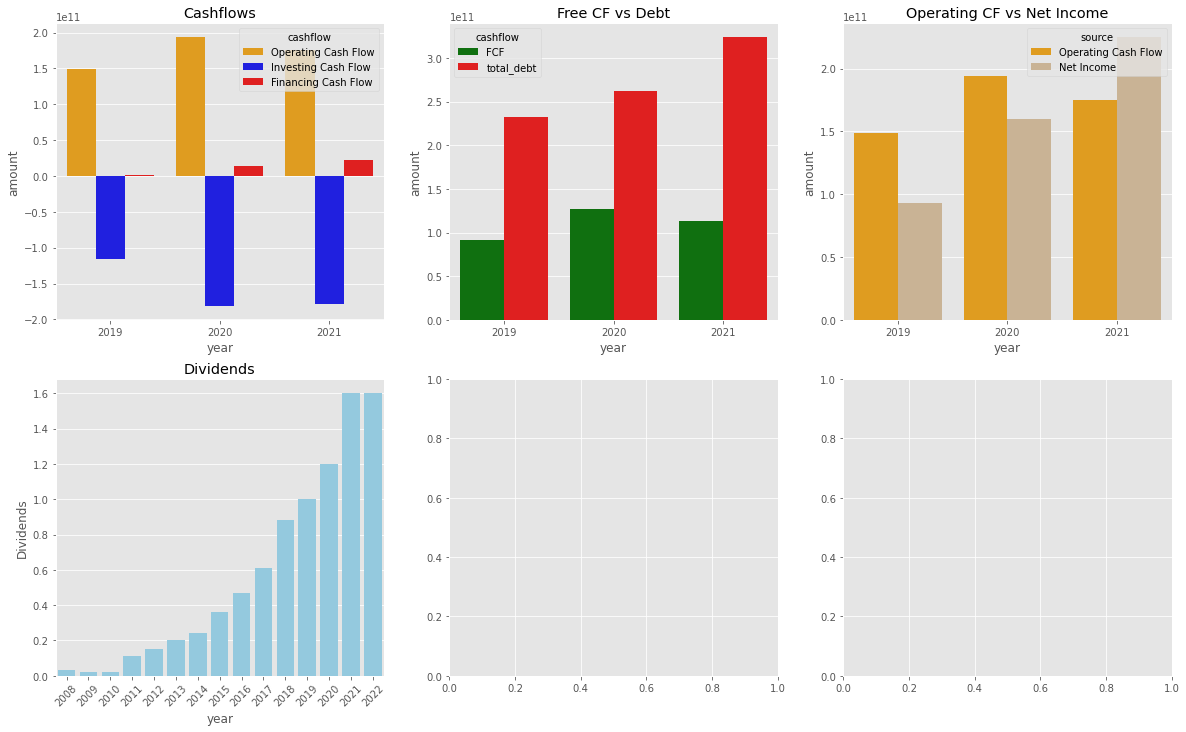

In [508]:
fig, axes = plt.subplots(2, 3,figsize=(20,12))


cashflow_df = df[["year","Operating Cash Flow","Investing Cash Flow", "Financing Cash Flow"]]
cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot(x= "year", y="amount", data= cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis, ax=axes[0,0])
axes[0,0].set(title="Cashflows")

fcf_df = df[["year","FCF", "total_debt"]]
fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot(x= "year", y="amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis, ax=axes[0,1])
axes[0,1].set(title="Free CF vs Debt")

cashflow_income= df[["year","Operating Cash Flow",'Net Income']]
cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot(x="year", y="amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis,ax=axes[0,2])
axes[0,2].set(title="Operating CF vs Net Income")


#dividends already adjusted for stock split according to yahoo finance
dividend_history = ticker.actions
dividend_history = dividend_history.rename_axis('year').reset_index()
dividend_history["year"] = pd.DatetimeIndex(dividend_history["year"]).year
dividend_history = dividend_history[dividend_history["Stock Splits"]==0]
dividend_history = dividend_history[["year", "Dividends"]]
dividend_history = dividend_history.groupby("year").sum()

if len(dividend_history)>0:
    sns.barplot(x = "year", y= "Dividends", data=dividend_history.reset_index(), color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set(title="Dividends")
else:
    sns.barplot(x = axis, y=[0] * len(axis) ,color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)   
    axes[1,0].set(title="Dividends")
    
# #to add FCF/Debt in 2nd graph

# # add revenue vs gross profit vs net income

## balancesheet

In [509]:
# BS[["Current Liabilities", 'Payables And Accrued Expenses']]

[Text(0.5, 1.0, 'Current Ratio and Debt to Equity')]

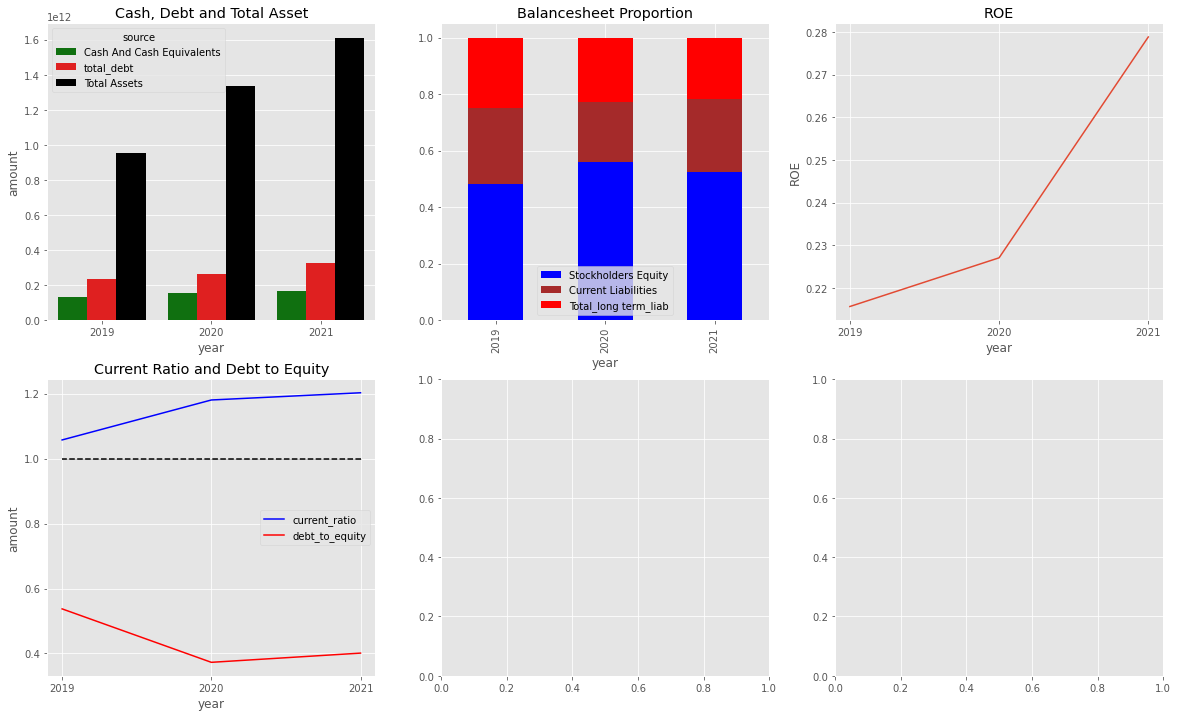

In [510]:
fig2, axes = plt.subplots(2, 3,figsize=(20,12))

balancesheet_prop= df[["year",'Cash And Cash Equivalents', "total_debt", 'Total Assets']]
balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot(x ="year",y= "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis,ax=axes[0,0])
axes[0,0].set(title="Cash, Debt and Total Asset")

balancesheet_df = BS[["year",'Stockholders Equity','Current Liabilities','Total Liabilities Net Minority Interest']]
# balancesheet_df = BS[["year",'Stockholders Equity','Payables And Accrued Expenses','Total Liabilities Net Minority Interest']]
balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liabilities Net Minority Interest"] - balancesheet_df["Current Liabilities"] 
# balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liabilities Net Minority Interest"] - balancesheet_df["Payables And Accrued Expenses"] 
balancesheet_df.drop("Total Liabilities Net Minority Interest",axis="columns", inplace =True)
balancesheet_df = balancesheet_df.set_index("year").sort_index()
balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'], ax=axes[0,1])
axes[0,1].set(title="Balancesheet Proportion")

sns.lineplot(x=df["year"], y= df["ROE"], ax=axes[0,2])
axes[0,2].invert_xaxis()
axes[0,2].set(title="ROE")

bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
sns.lineplot(x= bs_ratio_df["year"], y= bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"], ax=axes[1,0])
sns.lineplot(x= bs_ratio_df["year"], y=1, color = "black", linestyle="--", ax=axes[1,0])
axes[1,0].invert_xaxis()
axes[1,0].set(title="Current Ratio and Debt to Equity")

# WACC calculations

## Extract lates year data

In [511]:
latest_year = df.iloc[0]

## debt section 

In [512]:
IS.columns

Index(['year', 'Total Revenue', 'Operating Revenue', 'Cost Of Revenue',
       'Gross Profit', 'Operating Expense',
       'Selling General And Administration',
       'General And Administrative Expense', 'Selling And Marketing Expense',
       'Other Operating Expenses', 'Operating Income',
       'Net Non Operating Interest Income Expense',
       'Interest Income Non Operating', 'Interest Expense Non Operating',
       'Special Income Charges', 'Write Off', 'Other Special Charges',
       'Other Non Operating Income Expenses', 'Pretax Income', 'Tax Provision',
       'Net Income Common Stockholders', 'Net Income',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Minority Interests',
       'Otherunder Preferred Stock Dividend', 'Average Dilution Earnings',
       'Diluted NI Availto Com Stockholders', 'Basic EPS', 'Diluted EPS',
       'Basic Average Shares', 'Diluted Average Shares',
       'Total Operating Income As Reported', 'T

In [515]:
possible_interest_expression = ["Interest Expense", "Interest Expense Non Operating", 'Net Non Operating Interest Income Expense']
for i in possible_interest_expression:
    if i in latest_year.index:
        interest_expression = i
        print("interest expression is expressed as \'{}\' in income statement".format(interest_expression))
        break

print("Latest interest expenditure is: {}".format(latest_year[interest_expression])) 

interest expression is expressed as 'Interest Expense' in income statement
Latest interest expenditure is: 7918000000.0


In [516]:
debt = latest_year["total_debt"]

total_wacc_value = debt + market_cap
total_wacc_value

debt_weight = debt/total_wacc_value

if abs(latest_year[interest_expression]) != 0 and debt!=0:
    debt_cost = abs(latest_year[interest_expression]) / debt
elif abs(latest_year[interest_expression]) == 0 and debt==0:
    debt_cost = 0
elif abs(latest_year[interest_expression]) != 0 and debt==0:
    debt_cost = 0
else:
    debt_cost = 0

tax_rate = latest_year['Tax Provision'] / latest_year['Pretax Income']

In [517]:
print("interest rate of debt of company is: {}".format(debt_cost*100))
print("total debt of company is: {}".format(debt))
print("total maketcap of company is: {}".format(market_cap))
print("total weighted value of company is (debt + market cap): {}".format(total_wacc_value))
print("equity portion is: {}".format(market_cap/total_wacc_value))

interest rate of debt of company is: 2.4477859253855
total debt of company is: 323476000000.0
total maketcap of company is: 3468854034432
total weighted value of company is (debt + market cap): 3792330034432.0
equity portion is: 0.9147025714895489


## equity section

In [518]:
if beta == None:
    beta = 1
beta

0.558431

In [519]:
equity_weight =  market_cap/total_wacc_value

equity_cost = risk_free_rate +  beta*(market_return_rate-risk_free_rate)
equity_cost

0.0691784838

## WACC

In [521]:
wacc = ((equity_weight * equity_cost) + (debt_weight * debt_cost * (1-tax_rate))) + 1
wacc

1.0651951776063966

# Discounted Growth Model

## a) Cashflow

In [522]:
# averge growth rate
ocf_history = list(df['Operating Cash Flow'])
DCF_valuation_report(ocf_history)

based on average year-on-year growth, intrinsic value is: 224.7694872769469
based on CAGR, intrinsic value is: 203.90611911491843


## b) Income

In [523]:
ic_history = list(df['Net Income Common Stockholders'])
DCF_valuation_report(ic_history)

based on average year-on-year growth, intrinsic value is: 869.0377116243328
based on CAGR, intrinsic value is: 857.0496843524694


## c) Free Cash Flow

In [524]:
fcf_history = list(df["FCF"])
DCF_valuation_report(fcf_history)

based on average year-on-year growth, intrinsic value is: 174.23786422352438
based on CAGR, intrinsic value is: 149.92348430457176


# Dividend Discount Model 

## a) perpetual dividend growth 

In [525]:
#get the only completed years with all dividends paid out. Company with fiscal year at the start of year still haven't 
#completed dividend pay out for the year
dividend_year = []
if axis[-1] == current_year:
    for i in range(0, len(axis)): 
        dividend_year.append(int(axis[i])-1)
        print(dividend_year[i])
else: 
    dividend_year = [int(year) for year in axis]

In [526]:
if len(dividend_history)>0:
    #filter the last 4 years of dividends payment
    dividend_history = dividend_history[dividend_history.index.isin(dividend_year)]
    dividend_history = dividend_history.sort_index(ascending=False)
    dividend_history = list(dividend_history["Dividends"])
    DDM_valuation = perpetual_growth_valuation(dividend_history)
else: 
    DDM_valuation = 0
 
print("past 4 complete yearly dividend payout are: ", dividend_history)
print("DDM valuations is: ", DDM_valuation)

past 4 complete yearly dividend payout are:  [1.6, 1.2, 1.0]
DDM valuations is:  -17.091376696248865


### b) perpetual FCF growth

In [527]:
PFCF_valuation = perpetual_growth_valuation(fcf_history)/shares
print("Assuming perpetual FCF growth at last 3 years' rate. Valuation is: {}".format(PFCF_valuation))

Assuming perpetual FCF growth at last 3 years' rate. Valuation is: 51.904366443681674


# Valuation Comparison

<BarContainer object of 1 artists>

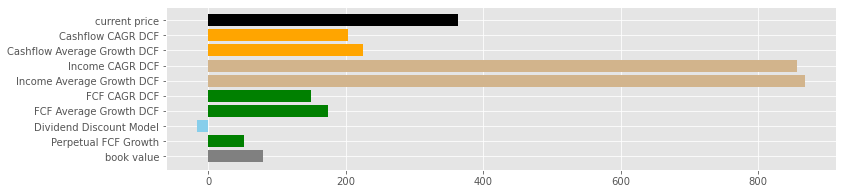

In [528]:
ax = plt.figure(figsize=(12, 3))

plt.barh("book value", book_value, color="grey")

plt.barh("Perpetual FCF Growth", PFCF_valuation, color="green")
plt.barh("Dividend Discount Model", DDM_valuation, color="skyblue")

plot_value("FCF Average Growth DCF", get_DCF_value, fcf_history, "green")
plot_value("FCF CAGR DCF", get_cagr_DCF_value, fcf_history, "green")

plot_value("Income Average Growth DCF", get_DCF_value,ic_history, "tan")
plot_value("Income CAGR DCF", get_cagr_DCF_value,ic_history, "tan")

plot_value("Cashflow Average Growth DCF", get_DCF_value,ocf_history, "orange")
plot_value("Cashflow CAGR DCF", get_cagr_DCF_value,ocf_history, "orange")

plt.barh("current price", current_price, color="black")

# Analyst's recommendations

<AxesSubplot:>

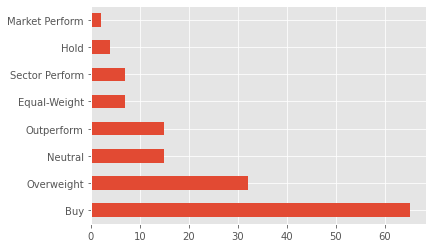

In [412]:
ticker.recommendations["To Grade"]\
    .value_counts()\
    .head(8)\
    .plot(kind="barh")

# Other Matrices

In [413]:
PE_ratio = ticker.info["trailingPE"]
PE_ratio

6594.0005

In [414]:
ticker.info["trailingPegRatio"]

0.9779

In [415]:
ticker.info["payoutRatio"]

0

# Development area

## cashflows

In [ ]:
# axis = list(df["year"])
# axis = sorted(axis)
# axis

In [ ]:
# cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
# cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis)

In [ ]:
# fcf_df = df[["year","FCF", "total_debt"]]
# fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis)

In [ ]:
# cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
# cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis)

## balance sheet

In [ ]:
# balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
# balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis)

In [ ]:
# balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
# balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
# balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
# balancesheet_df = balancesheet_df.set_index("year").sort_index()
# balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
# balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'])

In [ ]:
# ax = sns.lineplot(df["year"], df["ROE"])
# ax.invert_xaxis()
# ax.set(title="ROE")
# ax.legend()

In [ ]:
# bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
# bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
# ax = sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"])
# ax = sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--")
# ax.invert_xaxis()
# ax.legend()

In [21]:
ticker.info.keys()

dict_keys(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge', 'address1', 'industry', 'ebitdaMargins', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda', 'targetLowPrice', 'recommendationKey', 'grossProfits', 'freeCashflow', 'targetMedianPrice', 'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets', 'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity', 'returnOnEquity', 'targetHighPrice', 'totalCash', 'totalDebt', 'totalRevenue', 'totalCashPerShare', 'financialCurrency', 'revenuePerShare', 'quickRatio', 'recommendationMean', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue', 'beta3Year', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'f